In [1]:
import pandas as pd
import numpy as np
import mma
import skimage
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import scipy

from IPython.display import HTML
from matplotlib.lines import Line2D
import matplotlib.colors as mpl_colors
import seaborn as sns

mpl_named_colors = ['gray', 'g', 'y', 'r', 'k', 'c']

In [8]:
import importlib
mma = importlib.reload(mma)

In [2]:
with open('./unique_good_dirs_nodatadirs.txt', 'r') as f:
    exp_dirs = f.read().splitlines()
i = 0

In [3]:
def plot_positions(cor_pos_df, out_fn=None):
    plt.figure(figsize=(18,18))
    n_pads = len(cor_pos_df.groupby('pad'))
    pad_inds = np.unique(cor_pos_df.pad.values)
    colors = sns.color_palette('Set1', n_colors=n_pads)
    colors_dict = dict(zip(pad_inds, colors))
    for p_i in cor_pos_df.index:
        point_color = colors_dict[np.int(cor_pos_df.loc[p_i,"pad"])]
        plt.plot(np.float(cor_pos_df.x[p_i]),
                 -np.float(cor_pos_df.y[p_i]),
                 '.',
                 label=cor_pos_df.pad[p_i],
                 ms=20,
                 c=point_color)
        plt.text(np.float(cor_pos_df.x[p_i]),
                 -np.float(cor_pos_df.y[p_i]),
                 '{}'.format(cor_pos_df.loc[p_i, 'label']),
                 fontsize=14,
                 rotation=15)
    handles = [Line2D([0],[0],color=colors[xx],marker='o',label=xx) for xx in np.arange(n_pads)]
    plt.legend(handles=handles)
    plt.gca().set_aspect('equal')
#     plt.savefig(out_fn)
#     plt.close('all')


In [4]:
def write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
    # Get movie metadata
    sub_fdf = files_df.loc[files_df.pad==pad_ind,:]
    n_chan, chan_ind_list, chan_names, im_width, im_height = mma.get_exp_summary_from_fn(files_df.fn.values[0])
    n_frames = files_df.frame.max()+1
    pixel_size = pixel_size * scale
    h, w = im_height//scale, im_width//scale
    rh, rw = skimage.transform.rotate(np.ones((h,w)), rotation, resize=True).shape
    uint_max = 65535
    # Setup plotting variables
    plt.close('all')
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()])/pixel_size + rw*np.array([0,1])
    ylims = np.array([pad_df.y.min(), pad_df.y.max()])/pixel_size + rh*np.array([0,1])
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    while fig_h > 1e5 or fig_w > 1e5:
        fig_h, fig_w = np.array([fig_h, fig_w])/5
    # Define helper functions
    def load_img(frame, pos, channel, rotation=rotation, scale=scale, sigma=3):
        frame_bool = files_df.frame==frame
        pos_bool = files_df.pos==pos
        chan_bool = files_df.channel == channel
        indx_bool = (frame_bool)&(pos_bool)&(chan_bool)
        if sum(indx_bool) < 1:
            error_msg = 'Image not found when printing {}: pad:{} frame:{} pos:{} channel:{}'
            error_msg = error_msg.format(out_fn, pad_ind, frame, pos, channel)
            print(error_msg)
            return skimage.transform.rotate(np.zeros((rh,rw)),rotation,resize=True)
        fn = files_df.loc[indx_bool,'fn'].values[0]
        try:
            img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        except Exception as error:
            print('import img error {}'.format(fn))
            raise error
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation, resize=True)

    pad_arr = np.zeros((pad_h, pad_w, n_chan))
    chan_vec = np.array(chan_ind_list)
    pos_lims = (pad_df[['x','y']]/pixel_size).astype(np.int)
    count_arr = np.zeros((pad_h, pad_w))
    img_arr = skimage.transform.rotate(np.ones((h,w)),rotation,resize=True)
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+rh,x0:x0+rw] += img_arr
    uncovered_arr = count_arr<=0
    covered_arr = count_arr>0
    count_arr[count_arr<=0] = 1

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((rh,rw))
        bg_arr = np.zeros((rh,rw))
        # get background image
        bg_pos_list = [4,5,6,21,22]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
#             bg_arr[:] = 0
#             if channel != 0:
#                 bg_arr += np.median([load_img(0*frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
#             gb_pad = files_df.groupby(['pad','frame','channel'])
#             gb_pos = files_df.groupby(('pos','frame','channel'))
#             fns = gb_pad.get_group((pad_ind,frame_ind,channel)).fn
#             imgs = [load_img(frame_ind, pos, channel) for pos in pos_list]
#             h, w = imgs[0].shape
#             bg_arr = np.median(np.concatenate([img.reshape((rh, rw, 1)) for img in imgs],axis=2),axis=2)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
#                 bg_arr[:] = 0
#                 bg_arr += load_img(0, pos, channel, sigma=30)
                pad_arr[y0:y0+rh,x0:x0+rw,chan_i] += im_arr# - bg_arr
            pad_arr[:,:,chan_i] /= count_arr

    def animate(i):
        img_arr = np.zeros((pad_h, pad_w, 3))
        pad_arr[:] = 0
        get_frame_arr(i)
        # For no-bg gifs, normalize relative to the middle frame.
        # Use contrast-stretching approach, where the bounds are the middle 90 percentile
        norm_vec = []
        for chan_ind in np.arange(n_chan):
            frame_vals = pad_arr[:,:,chan_ind][covered_arr].flatten()
            frame_vals = np.sort(frame_vals)
            frame_n = len(frame_vals)
            ind_min, ind_max = np.array([0.05*frame_n, 0.95*frame_n],dtype=np.int)
            vmin, vmax = frame_vals[ind_min], frame_vals[ind_max]
            vmin = np.max([0, vmin])
            vmax = np.max([vmax+vmin,vmin*2])
            norm_fn = mpl_colors.Normalize(vmin, vmax, clip=True)
            norm_vec.append(norm_fn)
        for chan_ind, chan_slot in enumerate(chan_vec):
            norm = norm_vec[chan_ind]
            chan_arr = pad_arr[:,:,chan_ind:chan_ind+1]
            color_vec = mpl_colors.to_rgb(mpl_named_colors[chan_slot])
            img_arr += np.concatenate([norm(chan_arr)*color_val for color_val in color_vec],axis=2)
        im.set_array(img_arr)

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    img_arr = np.zeros((pad_h, pad_w, 3))
    im = ax.imshow(img_arr.copy(), interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    xticks = np.arange(0,pad_w,500/pixel_size)
    xlabs = ['{:0.2f}'.format(xx) for xx in xticks*pixel_size]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabs)
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    animate(frame_ind)
    return fig, pad_arr
#     fig.savefig(out_fn)
#     plt.close('all')


In [ ]:
def write_movie_no_bg(out_fn, flip, xlims, pad_ind, cross_df, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
    # Get movie metadata
    cross_gb = cross_df.groupby(['pad','frame','channel'])
    sub_fdf = files_df.loc[files_df.pad==pad_ind,:]
    n_chan, chan_ind_list, chan_names, im_width, im_height = mma.get_exp_summary_from_fn(files_df.fn.values[0])
    n_frames = files_df.frame.max()+1
    frame_vec = np.sort(np.unique(files_df.frame.values))
    pixel_size = pixel_size * scale
    h, w = im_height//scale, im_width//scale
    rh, rw = skimage.transform.rotate(np.ones((h,w)), rotation, resize=True).shape
    uint_max = 65535
    # Setup plotting variables
    plt.close('all')
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()])/pixel_size + rw*np.array([0,1])
    ylims = np.array([pad_df.y.min(), pad_df.y.max()])/pixel_size + rh*np.array([0,1])
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    while fig_h > 1e5 or fig_w > 1e5:
        fig_h, fig_w = np.array([fig_h, fig_w])/5
    # Define helper functions
    def load_img(frame, pos, channel, rotation=rotation, scale=scale, sigma=3, files_df=files_df):
        frame_bool = files_df.frame==frame
        pos_bool = files_df.pos==pos
        chan_bool = files_df.channel == channel
        indx_bool = (frame_bool)&(pos_bool)&(chan_bool)
        if sum(indx_bool) < 1:
            error_msg = 'Image not found when printing {}: pad:{} frame:{} pos:{} channel:{}'
            error_msg = error_msg.format(out_fn, pad_ind, frame, pos, channel)
            print(error_msg)
            return skimage.transform.rotate(np.zeros((rh,rw)),rotation,resize=True)
        fn = files_df.loc[indx_bool,'fn'].values[0]
        try:
            img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        except Exception as error:
            print('import img error {}'.format(fn))
            raise error
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation, resize=True)

    pad_arr = np.zeros((pad_h, pad_w, n_chan))
    chan_vec = np.array(chan_ind_list)
    pos_lims = (pad_df[['x','y']]/pixel_size).astype(np.int)
    count_arr = np.zeros((pad_h, pad_w))
    img_arr = skimage.transform.rotate(np.ones((h,w)),rotation,resize=True)
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+rh,x0:x0+rw] += img_arr
    uncovered_arr = count_arr<=0
    covered_arr = count_arr>0
    count_arr[count_arr<=0] = 1

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((rh,rw))
        bg_arr = np.zeros((rh,rw))
        # get background image
        bg_pos_list = [213,214,215,216] #200606
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                bg_arr[:] = 0
                bg_arr += load_img(0, pos, channel, sigma=30)
                pad_arr[y0:y0+rh,x0:x0+rw,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr
    
    def animate(i):
        img_arr = np.zeros((pad_h, pad_w, 3))
        pad_arr[:] = 0
        get_frame_arr(i)
        # For no-bg gifs, normalize relative to the middle frame.
        # Use contrast-stretching approach, where the bounds are the middle 90 percentile
        norm_vec = []
        for chan_ind in np.arange(n_chan):
            frame_vals = pad_arr[:,:,chan_ind][covered_arr].flatten()
            frame_vals = np.sort(frame_vals)
            frame_n = len(frame_vals)
            ind_min, ind_max = np.array([0.05*frame_n, 0.95*frame_n],dtype=np.int)
            vmin, vmax = frame_vals[ind_min], frame_vals[ind_max]
            vmin = np.max([0, vmin])
            vmax = np.max([vmax+vmin,vmin*2])
            norm_fn = mpl_colors.Normalize(vmin, vmax, clip=True)
            norm_vec.append(norm_fn)
        for chan_ind, chan_slot in enumerate(chan_vec):
            norm = norm_vec[chan_ind]
            chan_arr = pad_arr[:,:,chan_ind:chan_ind+1]
            color_vec = mpl_colors.to_rgb(mpl_named_colors[chan_slot])
            img_arr += np.concatenate([norm(chan_arr)*color_val for color_val in color_vec],axis=2)
            key = (pad, i, chan_slot)
            if key in cross_gb.groups.keys():
                segs = vl.get_segments()
                xval = cross_gb.get_group(key).x.mean()/pixel_size
                if flip==1:
                    xval = (pad_w-xlims_vec[pad][1])+xval
                else:
                    xval = xval+xlims_vec[pad][0]
                segs[chan_ind][:,0]=xval
                segs = vl.set_segments(segs)
        if flip==1:
            im.set_array(img_arr[:,::-1,:])
        else:
            im.set_array(img_arr)
        return im, vl
    
    def init():
        out = animate(0)
        return out

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    img_arr = np.zeros((pad_h, pad_w, 3))
    vl_colors = [mpl_colors.to_rgb(mpl_named_colors[chan_slot]) for chan_slot in chan_ind_list]
    vl = ax.vlines([0]*n_chan,
                   [0]*n_chan,
                   [pad_h]*n_chan,
                   colors=vl_colors,
                   lw=[10]*n_chan, animated=True)
    
    im = ax.imshow(img_arr.copy(), interpolation='none',animated=True)
    xticks = np.arange(0,pad_w,500/pixel_size)
    xlabs = ['{:0.2f}'.format(xx) for xx in xticks*pixel_size]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabs)
    ax.set_yticks([])
    ax.set_xlim([0,pad_w])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    def init():
        out = animate(0)
        return out
    
    init()
    anim = anm.FuncAnimation(fig, animate, interval=200, frames=frame_vec, init_func=init)
    plt.close('all')
    anim.save(out_fn, dpi=80, fps=1, writer='pillow')
#     return anim
#     return fig, pad_arr
#     fig.savefig(out_fn)
#     plt.close('all')


In [ ]:
def write_frame_no_bg(frame_ind, flip, xlims, pad_ind, cross_df, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
    # Get movie metadata
    cross_gb = cross_df.groupby(['pad','frame','channel'])
    sub_fdf = files_df.loc[files_df.pad==pad_ind,:]
    n_chan, chan_ind_list, chan_names, im_width, im_height = mma.get_exp_summary_from_fn(files_df.fn.values[0])
    n_frames = files_df.frame.max()+1
    frame_vec = np.sort(np.unique(files_df.frame.values))
    pixel_size = pixel_size * scale
    h, w = im_height//scale, im_width//scale
    rh, rw = skimage.transform.rotate(np.ones((h,w)), rotation, resize=True).shape
    uint_max = 65535
    # Setup plotting variables
    plt.close('all')
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()])/pixel_size + rw*np.array([0,1])
    ylims = np.array([pad_df.y.min(), pad_df.y.max()])/pixel_size + rh*np.array([0,1])
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    while fig_h > 1e5 or fig_w > 1e5:
        fig_h, fig_w = np.array([fig_h, fig_w])/5
    # Define helper functions
    def load_img(frame, pos, channel, rotation=rotation, scale=scale, sigma=3, files_df=files_df):
        frame_bool = files_df.frame==frame
        pos_bool = files_df.pos==pos
        chan_bool = files_df.channel == channel
        indx_bool = (frame_bool)&(pos_bool)&(chan_bool)
        if sum(indx_bool) < 1:
            error_msg = 'Image not found when printing {}: pad:{} frame:{} pos:{} channel:{}'
            error_msg = error_msg.format(out_fn, pad_ind, frame, pos, channel)
            print(error_msg)
            return skimage.transform.rotate(np.zeros((rh,rw)),rotation,resize=True)
        fn = files_df.loc[indx_bool,'fn'].values[0]
        try:
            img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        except Exception as error:
            print('import img error {}'.format(fn))
            raise error
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation, resize=True)

    pad_arr = np.zeros((pad_h, pad_w, n_chan))
    chan_vec = np.array(chan_ind_list)
    pos_lims = (pad_df[['x','y']]/pixel_size).astype(np.int)
    count_arr = np.zeros((pad_h, pad_w))
    img_arr = skimage.transform.rotate(np.ones((h,w)),rotation,resize=True)
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+rh,x0:x0+rw] += img_arr
    uncovered_arr = count_arr<=0
    covered_arr = count_arr>0
    count_arr[count_arr<=0] = 1

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((rh,rw))
        bg_arr = np.zeros((rh,rw))
        # get background image
        bg_pos_list = [4,5,6,21,22]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                bg_arr[:] = 0
                bg_arr += load_img(0, pos, channel, sigma=30)
                pad_arr[y0:y0+rh,x0:x0+rw,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr
            
    def animate(i):
        img_arr = np.zeros((pad_h, pad_w, 3))
        pad_arr[:] = 0
        get_frame_arr(i)
        # For no-bg gifs, normalize relative to the middle frame.
        # Use contrast-stretching approach, where the bounds are the middle 90 percentile
        norm_vec = []
        for chan_ind in np.arange(n_chan):
            frame_vals = pad_arr[:,:,chan_ind][covered_arr].flatten()
            frame_vals = np.sort(frame_vals)
            frame_n = len(frame_vals)
            ind_min, ind_max = np.array([0.05*frame_n, 0.95*frame_n],dtype=np.int)
            vmin, vmax = frame_vals[ind_min], frame_vals[ind_max]
            vmin = np.max([0, vmin])
            vmax = np.max([vmax+vmin,vmin*2])
            norm_fn = mpl_colors.Normalize(vmin, vmax, clip=True)
            norm_vec.append(norm_fn)
        for chan_ind, chan_slot in enumerate(chan_vec):
            norm = norm_vec[chan_ind]
            chan_arr = pad_arr[:,:,chan_ind:chan_ind+1]
            color_vec = mpl_colors.to_rgb(mpl_named_colors[chan_slot])
            img_arr += np.concatenate([norm(chan_arr)*color_val for color_val in color_vec],axis=2)
            key = (pad, i, chan_slot)
            if key in cross_gb.groups.keys():
                segs = vl.get_segments()
                xval = cross_gb.get_group(key).x.mean()/pixel_size
                if flip==1:
                    xval = (pad_w-xlims_vec[pad][1])+xval
                else:
                    xval = xval+xlims_vec[pad][0]
                segs[chan_ind][:,0]=xval
                segs = vl.set_segments(segs)
        if flip==1:
            im.set_array(img_arr[:,::-1,:])
        else:
            im.set_array(img_arr)
        return im, vl
    
    def init():
        out = animate(0)
        return out

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    img_arr = np.zeros((pad_h, pad_w, 3))
    vl_colors = [mpl_colors.to_rgb(mpl_named_colors[chan_slot]) for chan_slot in chan_ind_list]
    vl = ax.vlines([0]*n_chan,
                   [0]*n_chan,
                   [pad_h]*n_chan,
                   colors=vl_colors,
                   lw=[10]*n_chan, animated=True)
    
    im = ax.imshow(img_arr.copy(), interpolation='none',animated=True)
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    xticks = np.arange(0,pad_w,500/pixel_size)
    xlabs = ['{:0.2f}'.format(xx) for xx in xticks*pixel_size]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabs)
    ax.set_yticks([])
    ax.set_xlim([0,pad_w])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()
    init()
    animate(frame_ind)
    return fig
#     anim = anm.FuncAnimation(fig, animate, interval=200, frames=frame_vec)
#     plt.close('all')
#     anim.save(out_fn, dpi=80, fps=1, writer='pillow')
#     return anim
#     return fig, pad_arr
#     fig.savefig(out_fn)
#     plt.close('all')


In [ ]:
def write_all_frame_no_bg(frame_ind, out_fn, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
    # Get movie metadata
    n_chan, chan_ind_list, chan_names, im_width, im_height = mma.get_exp_summary_from_fn(files_df.fn.values[0])
    n_frames = files_df.frame.max()+1
    pixel_size = pixel_size * scale
    h, w = im_height//scale, im_width//scale
    rh, rw = skimage.transform.rotate(np.ones((h,w)), rotation, resize=True).shape
    uint_max = 65535
    # Setup plotting variables
    plt.close('all')
    pad_df = cor_pos_df#.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()])/pixel_size + rw*np.array([-0.25,1.25])
    ylims = np.array([pad_df.y.min(), pad_df.y.max()])/pixel_size + rh*np.array([-0.25,1.25])
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    while fig_h > 1e4 or fig_w > 1e4:
        fig_h, fig_w = np.array([fig_h, fig_w])/500
    # Define helper functions
    def load_img(frame, pos, channel, rotation=rotation, scale=scale, sigma=3):
        frame_bool = files_df.frame==frame
        pos_bool = files_df.pos==pos
        chan_bool = files_df.channel == channel
        indx_bool = (frame_bool)&(pos_bool)&(chan_bool)
        if sum(indx_bool) < 1:
            error_msg = 'Image not found when printing {}: pad:{} frame:{} pos:{} channel:{}'
            error_msg = error_msg.format(out_fn, 0, frame, pos, channel)
            print(error_msg)
            return skimage.transform.rotate(np.zeros((rh,rw)),rotation,resize=True)
        fn = files_df.loc[indx_bool,'fn'].values[0]
        try:
            img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        except Exception as error:
            print('import img error {}'.format(fn))
            raise error
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation, resize=True)

    pad_arr = np.zeros((pad_h, pad_w, n_chan))
    chan_vec = np.array(chan_ind_list)
    pos_lims = (pad_df[['x','y']]/pixel_size).astype(np.int)
    count_arr = np.zeros((pad_h, pad_w))
    img_arr = skimage.transform.rotate(np.ones((h,w)),rotation,resize=True)
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+rh,x0:x0+rw] += img_arr
    uncovered_arr = count_arr<=0
    covered_arr = count_arr>0
    count_arr[count_arr<=0] = 1

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((rh,rw))
        # get background image
        # bg_pos_list = [83,89,95,101,107]
        # n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            # bg_arr[:] = 0
            # bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            gb_pad = files_df.groupby(['frame','channel'])
#             gb_pos = files_df.groupby(('pos','frame','channel'))
            fns = gb_pad.get_group((frame_ind,channel)).fn
#             imgs = [load_img(frame_ind, pos, channel) for pos in pos_list]
#             h, w = imgs[0].shape
#             bg_arr = np.median(np.concatenate([img.reshape((rh, rw, 1)) for img in imgs],axis=2),axis=2)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+rh,x0:x0+rw,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr

    def animate(i):
        img_arr = np.zeros((pad_h, pad_w, 3))
        pad_arr[:] = 0
        get_frame_arr(i)
        # For no-bg gifs, normalize relative to the middle frame.
        # Use contrast-stretching approach, where the bounds are the middle 90 percentile
        norm_vec = []
        for chan_ind in np.arange(n_chan):
            frame_vals = pad_arr[:,:,chan_ind][covered_arr].flatten()
            frame_vals = np.sort(frame_vals)
            frame_n = len(frame_vals)
            ind_min, ind_max = np.array([0.05*frame_n, 0.95*frame_n],dtype=np.int)
            vmin, vmax = frame_vals[ind_min], frame_vals[ind_max]
            vmax = np.max([vmax+vmin,vmin*2])
            norm_fn = mpl_colors.Normalize(vmin, vmax, clip=True)
            norm_vec.append(norm_fn)
        for chan_ind, chan_slot in enumerate(chan_vec):
            norm = norm_vec[chan_ind]
            chan_arr = pad_arr[:,:,chan_ind:chan_ind+1]
            color_vec = mpl_colors.to_rgb(mpl_named_colors[chan_slot])
            img_arr += np.concatenate([norm(chan_arr)*color_val for color_val in color_vec],axis=2)
        im.set_array(img_arr)

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    img_arr = np.zeros((pad_h, pad_w, 3))
    im = ax.imshow(img_arr.copy(), interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    xticklabels = np.arange(0, pad_w*pixel_size, 1e3)
    xticks = xticklabels/pixel_size
    yticklabels = np.arange(0, pad_h*pixel_size, 1e3)
    yticks = yticklabels/pixel_size
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    animate(frame_ind)
    return fig, pad_arr
#     fig.savefig(out_fn)
#     plt.close('all')


In [ ]:
# time_vec = [mma.Acquisition(fn).files_df.time.min() for fn in exp_dirs]
tstr_vec = [time.asctime(time.localtime(xx)) for xx in time_vec]

In [ ]:
with open('acq_times.txt','w') as f:
    f.writelines('\n'.join(tstr_vec))

In [ ]:
import time

In [ ]:
time.asctime?

In [ ]:
time.gmtime(acq.files_df.time.values[0])

In [ ]:
fn_list = [xx for xx in exp_dirs if '190313' in xx]
print(fn_list)

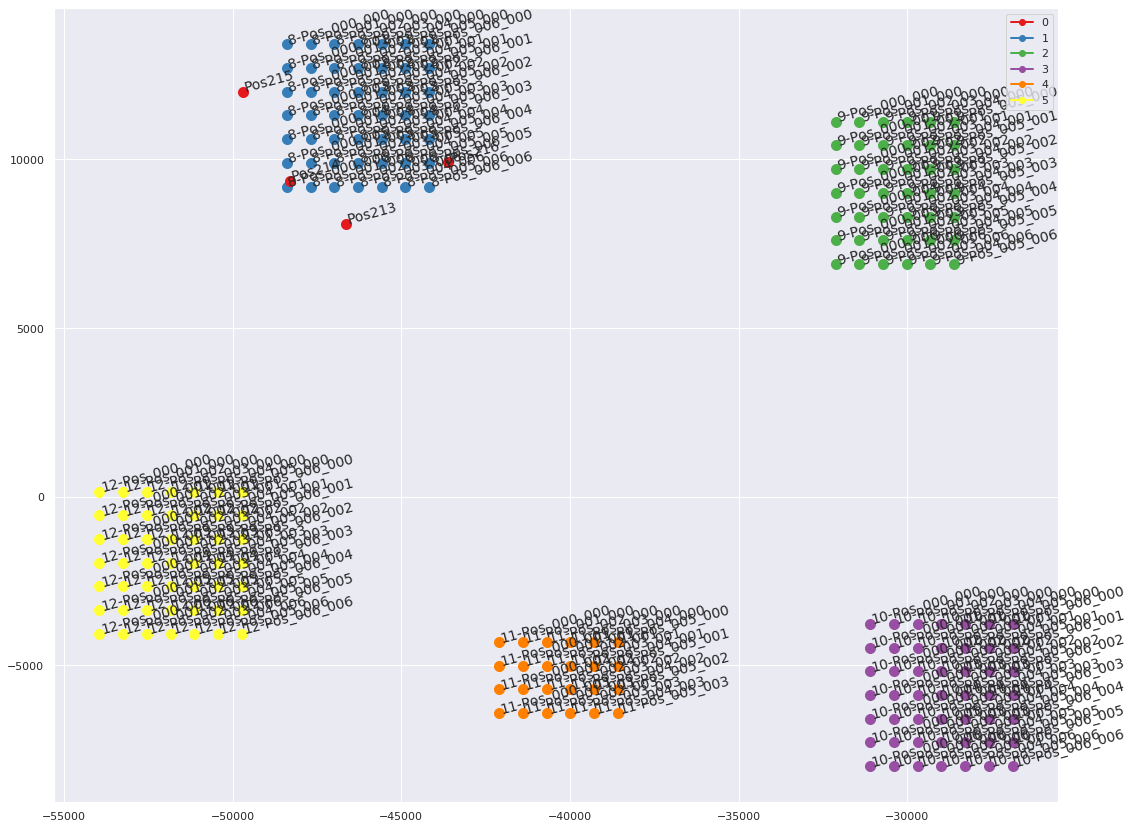

In [6]:
plot_positions(acq.cor_pos_df)

In [1]:
import importlib
mma = importlib.reload(mma)

NameError: name 'mma' is not defined

In [44]:
acq = mma.Acquisition('/groups/murray-biocircuits/jparkin/movies/200613_unordered/img_3')
acq.bg_pos_list = [213,214,215,216]

In [58]:
pad2helper = mma.WriteHelper(acq, 8, 5, 'comb')

In [66]:
pad2helper.get_frame_arr(9)

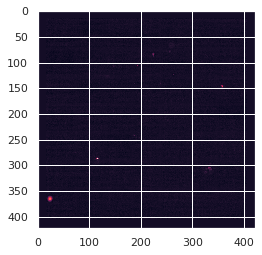

In [67]:
plt.imshow(pad2helper.pad_arr[:,:,1])

In [ ]:
for frame in [4,8,12,16]:
    acq.write_all_pad_frame_no_bg(frame,2)

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
cpdf = acq.cor_pos_df.copy()
cpdf_gb = cpdf.groupby('label')
pos_list = ['Pos14', 'Pos15']
sub_cpdf = pd.concat([cpdf_gb.get_group(xx) for xx in pos_list])
fdf_gb = acq.files_df.groupby('posname')
sub_fdf = pd.concat([fdf_gb.get_group(xx) for xx in pos_list])
for angle in np.linspace(3.125,4.375,5):
    fig = write_frame_no_bg(35, '', 1, sub_fdf, sub_cpdf, acq.pixel_size, 2, angle)
    plt.title(angle)
    plt.show(fig)

In [ ]:
plt.plot(pad_arr[:,:,2].mean(axis=0))

In [ ]:

for pad in np.arange(14):
    try:
        fig, pad_arr = write_frame_no_bg(9, '', pad, acq.files_df,acq.cor_pos_df, acq.pixel_size, 1, 0)
        plt.title(pad)
        xlims = xlims_vec[pad]
        plt.vlines(xlims[0], 0, pad_arr.shape[0],colors=['w'])
        plt.vlines(xlims[1], 0, pad_arr.shape[0],colors=['w'])
        plt.show(fig)
    except Exception as e:
        print(e)

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):

xlims_vec = [(100,3300),
         (400,3600),
         (450,3600),
         (500,3800),
         (50,3200),
         (300,3200),
         (300,3800),
         (400,3600),
         (400,4000),
         (800,4000),
         (450,3500),
         (400,3500),
         (400,4000),
         (900,4000)]
flip_vec = [0,0,0,1,0,0,1,0,0,0,0,0,0,0]
frame=10
for pad in np.arange(14):
#     try:
    out_fn = './anims/prog/pad_{}.gif'.format(pad)
    fig = write_frame_no_bg(12, flip_vec[pad], xlims_vec[pad], pad, cross_df, files_df, cor_pos_df, pixel_size, scale=1, rotation=0)
    plt.show(fig)
#         fig, pad_arr = write_frame_no_bg(11, '', pad, acq.files_df,acq.cor_pos_df, acq.pixel_size, 1, 0)
#         plt.title(pad)
#         xlims = xlims_vec[pad]
#         plt.vlines(xlims[0], 0, pad_arr.shape[0],colors=['w'])
#         plt.vlines(xlims[1], 0, pad_arr.shape[0],colors=['w'])
#         plt.show(fig)
#     except Exception as e:
#         print(e)

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):

xlims_vec = [(100,3300),
         (400,3600),
         (450,3600),
         (500,3800),
         (50,3200),
         (300,3200),
         (300,3800),
         (400,3600),
         (400,4000),
         (800,4000),
         (450,3500),
         (400,3500),
         (400,4000),
         (900,4000)]
flip_vec = [0,0,0,1,0,0,1,0,0,0,0,0,0,0]
frame=10
for pad in np.arange(14):
#     try:
    out_fn = './anims/prog/pad_{}.gif'.format(pad)
    sub_fdf = files_df.loc[(files_df.frame>6)&(files_df.frame<13)]
    write_movie_no_bg(out_fn, flip_vec[pad], xlims_vec[pad], pad, cross_df, files_df, cor_pos_df, pixel_size, scale=1, rotation=0)
    print(out_fn)
#         fig, pad_arr = write_frame_no_bg(11, '', pad, acq.files_df,acq.cor_pos_df, acq.pixel_size, 1, 0)
#         plt.title(pad)
#         xlims = xlims_vec[pad]
#         plt.vlines(xlims[0], 0, pad_arr.shape[0],colors=['w'])
#         plt.vlines(xlims[1], 0, pad_arr.shape[0],colors=['w'])
#         plt.show(fig)
#     except Exception as e:
#         print(e)

In [ ]:
cross_df

In [ ]:
acq.write_all_pad_gifs_no_bg()

In [ ]:
gb_pos_frame_chan = acq.files_df[['pos','frame','channel','fn']].groupby(['pos','frame','channel'])
arr = skimage.io.imread(gb_pos_frame_chan.get_group((200,8,3)).fn.values[0])
plt.imshow(arr)

In [ ]:
gb_pos_frame_chan = acq.files_df[['pos','frame','channel','fn']].groupby(['pos','frame','channel'])
arr = skimage.io.imread(gb_pos_frame_chan.get_group((98,8,3)).fn.values[0])
plt.imshow(arr)

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):

xlims_vec = [(100,3300),
         (400,3600),
         (450,3600),
         (500,3800),
         (50,3200),
         (300,3200),
         (300,3800),
         (400,3600),
         (400,4000),
         (800,4000),
         (450,3500),
         (400,3500),
         (400,4000),
         (900,4000)]
flip_vec = [0,0,0,1,0,0,1,0,0,0,0,0,0,0]
cross_gb = cross_df.groupby(['pad','frame','channel'])
frame=12
for pad in np.arange(6):
#     try:
    fig, pad_arr = write_frame_no_bg(frame, '', pad, acq.files_df,acq.cor_pos_df, acq.pixel_size, 1, 180)
    plt.title(pad)
#     xlims = xlims_vec[pad]
#     plt.vlines(xlims[0], 0, pad_arr.shape[0],colors=['w'])
#     plt.vlines(xlims[1], 0, pad_arr.shape[0],colors=['w'])
#     key = (pad,frame,3)
#     if key in cross_gb.groups.keys():
#         rxval = cross_gb.get_group((pad,frame,3)).x.mean()/pixel_size
#     else:
#         rxval=0
#     if flip_vec[pad]==1:
#         rxval = xlims[1]-rxval
#     else:
#         rxval += xlims[0]
#     key = (pad,frame,5)
#     if key in cross_gb.groups.keys():
#         cxval = cross_gb.get_group((pad,frame,5)).x.mean()/pixel_size
#     else:
#         cxval = 0
#     if flip_vec[pad]==1:
#         cxval = xlims[1]-cxval
#     else:
#         cxval = cxval+xlims[0]
#     plt.vlines([rxval, cxval],[0,0],[pad_arr.shape[0],pad_arr.shape[0]],colors=['r','c'],lw=[15,15])
    plt.show(fig)
#     except Exception as e:
#         print(e)

In [ ]:

xlims_vec = [(100,3300),
         (400,3600),
         (450,3600),
         (500,3800),
         (50,3200),
         (300,3200),
         (300,3800),
         (400,3600),
         (400,4000),
         (800,4000),
         (450,3500),
         (400,3500),
         (400,4000),
         (900,4000)]
flip_vec = [0,0,0,1,0,0,1,0,0,0,0,0,0,0]

In [ ]:
plt.figure(figsize=(20,8))
sub_pad_arr = pad_arr
plt.imshow(pad_arr[:,:,2] > skimage.filters.threshold_li(pad_arr[:,:,2]))
# plt.plot(pad_arr[:,:,1].sum(axis=0))

In [ ]:
# def analyze_pads(pad_ind, files_df, cor_pos_df, pixel_size, in_scale=2, out_scale=8, rotation=180):
in_scale = 1
out_scale = 16
files_df, cor_pos_df, pixel_size = acq.files_df.copy(), acq.cor_pos_df.copy(), acq.pixel_size
rotation=180

# Define helper functions
def load_img(frame, pos, channel, rotation=rotation, scale=in_scale, sigma=3, files_df=files_df):
    frame_bool = files_df.frame==frame
    pos_bool = files_df.pos==pos
    chan_bool = files_df.channel == channel
    indx_bool = (frame_bool)&(pos_bool)&(chan_bool)
    if sum(indx_bool) < 1:
        error_msg = 'Image not found frame:{} pos:{} channel:{}'
        error_msg = error_msg.format(frame, pos, channel)
        print(error_msg)
        return 0#skimage.transform.rotate(np.zeros((rh,rw)),rotation,resize=True)
    fn = files_df.loc[indx_bool,'fn'].values[0]
    try:
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
    except Exception as error:
        print('import img error {}'.format(fn))
        raise error
    img = skimage.transform.downscale_local_mean(img, (scale, scale))
    return skimage.transform.rotate(img, rotation, resize=True)

def thresh_helper(im_arr):
    uint_max = 65535
    im_arr = im_arr / uint_max
    w, h = im_arr.shape
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_arr, g_radius)
    im_smooth[im_smooth < 0] = 0

    thresh = skimage.filters.threshold_li(im_smooth)
    thresh = np.max([40/uint_max,thresh])
    im_bw = im_smooth > thresh
    if np.sum(im_bw) == 0 :
        return None
    return im_bw

def get_imgs(frame, pos, channel, in_scale, out_scale, in_sigma, out_sigma)
    # Load imgs, bg subtract, threshold
    im_arr = load_img(frame, pos, channel, scale=in_scale, sigma=in_sigma)
    im_bg = load_img(0, pos, channel, scale=in_scale, sigma=out_sigma)
    im_arr = im_arr - im_bg
    im_arr[im_arr<0] = 0
    im_bw = thresh_helper(im_arr)
    return im_arr, im_bg, im_bw

def process_img(df_row, cor_pos_df=cor_pos_df):
    meta_cols = ['pad','pos','fn','frame','channel','time']
    pad, pos, fn, frame, channel, im_time = df_row[meta_cols].values
    py, px = cor_pos_df.loc[pos,['y', 'x']]
    
    # Load imgs, bg subtract, threshold
    im_arr = load_img(frame, pos, channel, scale=in_scale, sigma=3)
    im_bg = load_img(0, pos, channel, scale=in_scale, sigma=15)
    im_arr = im_arr - im_bg
    im_arr[im_arr<0] = 0
    im_bw = thresh_helper(im_arr)
    
    data_cols = ['area', 'x','y','fluor']
    columns = data_cols + meta_cols
    if im_bw is None:
        return pd.DataFrame(columns=columns)
    # downsample
    arr_dwn = skimage.transform.downscale_local_mean(im_arr, (out_scale, out_scale))
    bw_dwn = skimage.transform.downscale_local_mean(im_bw, (out_scale, out_scale))
    dwn_h, dwn_w = bw_dwn.shape

    # make df
    index = np.arange(dwn_h*dwn_w)
    df = pd.DataFrame(columns=columns,index=index)
    for meta_col in meta_cols:
        df.loc[:,meta_col] = df_row[meta_col]

    # fill in with downsampled x, y, fluor, cell area
    scaled_ps = pixel_size*in_scale*out_scale
    x, y = scaled_ps*np.mod(index, dwn_w)+px, scaled_ps*(index//dwn_w)+py
    df.loc[index,data_cols] = np.array([bw_dwn.flatten(), x, y, arr_dwn.flatten()]).T
    return df

chan_df = files_df.loc[files_df.channel>0,:]
df = pd.concat([process_img(chan_df.loc[i,:], cor_pos_df) for i in chan_df.index], ignore_index=True)


In [ ]:

def get_imgs(frame, pos, channel, in_scale, out_scale, in_sigma, out_sigma):
    # Load imgs, bg subtract, threshold
    im_arr = load_img(frame, pos, channel, scale=in_scale, sigma=in_sigma)
    im_bg = load_img(0, pos, channel, scale=in_scale, sigma=out_sigma)
    im_arr = im_arr - im_bg
    im_arr[im_arr<0] = 0
    im_bw = thresh_helper(im_arr)
    
    arr_dwn = skimage.transform.downscale_local_mean(im_arr, (out_scale, out_scale))
    bw_dwn = skimage.transform.downscale_local_mean(im_bw, (out_scale, out_scale))
    
    return arr_dwn, bw_dwn

frame, pos, channel = 14, 88, 5
in_scale, out_scale = 1, 16
in_sigma, out_sigma = 3, 30
im_arr, im_bw = get_imgs(frame, pos, channel, in_scale, out_scale, in_sigma, out_sigma)

In [ ]:
plt.imshow(im_arr)
plt.figure()
plt.imshow(im_bw>9e-1)

In [ ]:
df_row = chan_df.iloc[102,:]
meta_cols = ['pad','pos','fn','frame','channel','time']
pad, pos, fn, frame, channel, im_time = df_row[meta_cols].values
py, px = cor_pos_df.loc[pos,['y', 'x']]

# Load imgs, bg subtract, threshold
im_arr = load_img(frame, pos, channel, scale=in_scale, sigma=3)
im_bg = load_img(0, pos, channel, scale=in_scale, sigma=15)
im_arr = im_arr - im_bg
im_arr[im_arr<0] = 0
im_bw = thresh_helper(im_arr)

data_cols = ['area', 'x','y','fluor']
columns = data_cols + meta_cols
# if im_bw is None:
    
#     return pd.DataFrame(columns=columns)
# downsample
arr_dwn = skimage.transform.downscale_local_mean(im_arr, (out_scale, out_scale))
bw_dwn = skimage.transform.downscale_local_mean(im_bw, (out_scale, out_scale))
dwn_h, dwn_w = bw_dwn.shape

In [ ]:
repr_picklist = pd.read_csv('./190313_repr_picklist.csv')
repr_picklist = repr_picklist.loc[repr_picklist.exp_inds>=0,:]
repr_picklist = repr_picklist.sort_values(by=['iptg','ahl'])
gb_expind = repr_picklist[['iptg','ahl','exp_inds']].groupby('exp_inds')

In [ ]:
gb_frame_chan = df.groupby(['frame','channel'])#,'frame'])
fig, axs = plt.subplots(14,1,figsize=(8,50))
for chan in [5,3]:
    sub_df = gb_frame_chan.get_group((12,chan)).copy()
    sub_df['normed'] = 0.0
    tmp_df = sub_df[['x','pad','fluor','area']]#.groupby(['x','frame']).agg(np.median).reset_index()
    gb_pad = tmp_df.groupby('pad')
    for ax_ind, pad in enumerate(repr_picklist.exp_inds):
        iptg, ahl = gb_expind.get_group(pad)[['iptg', 'ahl']].values[0]
        x_binned = np.arange(0,1e4,1e2)
        x_bins = zip(x_binned,x_binned+1e2)
        flip = flip_vec[pad]
        plot_df = gb_pad.get_group(pad)
        bg_df = plot_df.loc[plot_df.area<4e-1,:]
        plot_df = plot_df.loc[plot_df.area>9e-1,:]
        arr = plot_df.fluor.values#.flatten().reshape((16,16))
        arr2 = plot_df.area.values#.flatten().reshape((16,16))
        y = (arr*(arr2>0.99))/(arr2+1e-3)
        sub_df.loc[plot_df.index,'normed'] = y
        xlims = np.array(xlims_vec[pad])*acq.pixel_size
        x = plot_df.x.values# - xlims.min()
        x = np.abs(x-[x.min(),x.max()][flip])-xlims[0]
        xlims = np.sort(np.abs(xlims-[x.min(),x.max()][flip]))
        y_binned = np.zeros_like(x_binned)
        axs[ax_ind].plot(x, y,'.')
        for i, bin_lims in enumerate(x_bins):
            x_l, x_r = bin_lims
            bool_vec = (x>=x_l)&(x<x_r)
            if np.sum(bool_vec)>1:
                y_binned[i] = np.median(y[bool_vec])
        axs[ax_ind].plot(x_binned, y_binned,'-k')
        axs[ax_ind].set_ylim([0,2e4])
        axs[ax_ind].set_xlim(xlims-xlims[0])
        axs[ax_ind].set_title("pad:{} iptg:{}mM ahl:{}uM".format(pad,iptg,ahl))
fig.tight_layout()

In [ ]:
gb_stuff = binned_df.groupby(['pad','chan','frame','y'])
indx = gb_stuff.groups.keys()
cross_df = pd.DataFrame(index=indx, columns=['pad','chan','frame','y','xcross'])
for key, sub_df in gb_stuff:
    athresh = sub_df.nf > 3e3
    if np.sum(athresh.values):
        xval = np.nan
    else:
        xval = sub_df.loc[athresh,'x'].max()
    pad,chan,frame,yval = key
    cross_df.loc[key,:] = pad,chan,frame,yval,xval

In [ ]:
plt.imshow(f_arr)
_ = plt.xticks(np.arange(0,250,50),x_vec[np.arange(0,250,50)]//1)
# plt.xticklabels(x_vec[np.arange(0,250,50)])

In [ ]:
for frame in np.arange(20):
    tmp_df = occ_df.groupby(['pad','channel','frame']).get_group((2,5,frame))
    tmp_df = tmp_df[['area','fluor','x','y']].groupby(['x','y']).agg(np.mean).reset_index()
    arr_df = tmp_df.pivot(index='x',columns='y',values='area')
    x_vec = arr_df.index.values.copy()
#     x_vec = x_vec.max() - x_vec
    a_arr = tmp_df.pivot(index='x',columns='y',values='area').values.T
    f_arr = tmp_df.pivot(index='x',columns='y',values='fluor').values.T
    n_arr = f_arr/(a_arr+(a_arr==0))
    n_arr[a_arr<9.9e-2] = 0
    athresh = n_arr>2e3
    h, w = f_arr.shape
    for hi in np.arange(h):
        if np.any(athresh[hi,:]):
            _ = plt.plot(frame, np.max(x_vec[athresh[hi,:]]),'k.')

In [ ]:
key = (3,5)
sub_df = gb_pad.get_group(key)
pad, chan = key
avgd_df = sub_df[['area','fluor','x','y','time','frame']].groupby(['x','y','frame']).agg(np.mean).reset_index()
time_df = avgd_df[['frame','time']].groupby('frame').agg(np.mean)
area_v = avgd_df.area.values
fluor_v = avgd_df.fluor.values
normed_v = fluor_v / (area_v+(area_v==0))
normed_v[area_v>0.95]=0
threshed_v = normed_v > 1e4
plot_df = avgd_df.loc[threshed_v,['frame','y','x']].groupby(['frame','y']).agg(np.max).reset_index()

In [ ]:
occ_df = df.copy()
gb_pad = occ_df.groupby('pad')
for key, sub_df in gb_pad:
    flip = flip_vec[key]
    xlims = np.array(xlims_vec[key])*pixel_size
    x = sub_df['x'].values
    occ_df.loc[sub_df.index,'x'] = np.abs(x-[x.min(),x.max()][flip])-xlims[0]
    
occ_df.loc[:,'time'] = occ_df.loc[:,'time'] - occ_df.time.min()

In [ ]:
fig, axs = plt.subplots(14,2,figsize=(12,40))
# gb_pad = agg_df.reset_index().groupby(['pad','channel','y'])


bool_vec = (occ_df.x<7.5e3)&(occ_df.x>0)#&(occ_df.frame<13)
# athresh = occ_df.normed>2e3
# occ_vec = occ_df.area>0.0099
thresh_dict = {3:2.5e3,5:2.5e3}
occ_df['time'] = occ_df.time.values.astype(np.float)
occ_df['frame'] = occ_df.frame.values.astype(np.int)
gb_pad = occ_df.loc[bool_vec,:].groupby(['pad','channel'])#,'y','frame'])
out_df_list = []
for key, sub_df in gb_pad:
    # Rearrange
    pad, chan = key
    sub_cols = ['area','fluor','x','y','time','frame']
    gb_cols = ['x','y','frame']
    avgd_df = sub_df[sub_cols].groupby(gb_cols).agg(np.mean).reset_index()
    time_df = avgd_df[['frame','time']].groupby('frame').agg(np.mean)
    time_df['time'] = time_df['time']/3600
    
    # Threshold
    area_v = avgd_df.area.values
    fluor_v = avgd_df.fluor.values - avgd_df.loc[area_v<0.1,'fluor'].mean()
    normed_v = fluor_v / (area_v+(area_v==0))
    normed_v[area_v<0.99]=0
    threshed_v = normed_v > thresh_dict[chan]
    plot_df = avgd_df.loc[threshed_v,['frame','y','x']].groupby(['frame','y']).agg(np.max).reset_index()
    
    ax = axs[pad,chan//4]
    if not np.all(plot_df.frame>7):
        f_vec = plot_df.frame.values
        t_vec = time_df.loc[f_vec,'time'].values
        plot_df['time'] = t_vec
        plot_df['channel'] = chan
        plot_df['pad'] = pad
        out_df_list.append(plot_df)
        ax.plot(t_vec, plot_df.x.values, 'k.',alpha=0.3,ms=8)
        med_df = plot_df.groupby('frame').agg(np.mean).reset_index().sort_values(by='frame')
        f_vec = med_df.frame.values
        t_vec = time_df.loc[f_vec,'time'].values
        ax.plot(t_vec, med_df.x.values, 'r-')
    ax.set_title('pad:{} chan:{}'.format(pad,chan))
    ax.set_xlim([0,1.1*time_df.time.max()])
    ax.set_ylim([0,8e3])

fig.tight_layout()

In [ ]:
cross_df = pd.concat(out_df_list,ignore_index=True)

In [ ]:
cross_df['dxdt'] = np.nan
gb_ypad = cross_df.groupby(['y','pad','channel'])
for key, sub_df in gb_ypad:
    y, pad, chan = key
    sub_df = sub_df.sort_values(by='time')
    t_vec, x_vec = sub_df.time, sub_df.x
    dxdt_v = np.diff(x_vec)/np.diff(t_vec)
    cross_df.loc[sub_df.index[:-1],'dxdt'] = dxdt_v

In [ ]:
metadata = repr_picklist.groupby('exp_inds')
ahl_concs = np.unique(repr_picklist.ahl.values)
n_ahl = len(ahl_concs)
ahl_ticks = dict(zip(ahl_concs, np.arange(n_ahl)))
iptg_concs = np.unique(repr_picklist.iptg.values)
n_iptg = len(iptg_concs)
iptg_ticks = dict(zip(iptg_concs, np.arange(n_iptg)))

In [ ]:
metadata.get_group(pad)[['iptg', 'ahl']].values

In [ ]:
gb_padchan = cross_df.loc[np.isfinite(cross_df.dxdt),:].groupby(['pad','channel'])
fig, axs = plt.subplots(len(ahl_concs),2,figsize=(12,7))
for key, sub_df in gb_padchan:
    pad, chan = key
    iptg, ahl = metadata.get_group(pad)[['iptg', 'ahl']].values[0]
    iptg_tick = iptg_ticks[iptg]
    ahl_tick = ahl_ticks[ahl]
    agg_df = sub_df.groupby('time').agg(np.mean).reset_index()
    ax = axs[ahl_tick, chan//4]
    ax.plot(iptg_tick, agg_df.dxdt.mean(),'k.',ms=18)
    ax.set_xticks(np.arange(n_iptg))
    ax.set_xticklabels(iptg_concs)
    ax.set_title('AHL: {}uM'.format(ahl))
    ax.set_xlim([-1,n_iptg])
    ax.set_ylim([100,1500])
fig.tight_layout()

In [ ]:
plt.plot(repr_picklist.ahl, repr_picklist.iptg, '.')

In [ ]:
gb_padchan = cross_df.loc[np.isfinite(cross_df.dxdt),:].groupby(['pad','channel'])
fig, axs = plt.subplots(len(ahl_concs),2,figsize=(8,12))
for key, sub_df in gb_padchan:
    pad, chan = key
    iptg, ahl = metadata.get_group(pad)[['iptg', 'ahl']].values[0]
    iptg_tick = iptg_ticks[iptg]
    ahl_tick = ahl_ticks[ahl]
    agg_df = sub_df.groupby('time').agg(np.mean).reset_index()
    ax = axs[ahl_tick, chan//4]
    ax.plot(iptg_tick, agg_df.dxdt.mean(),'k.',ms=18)
    ax.set_xticks(np.arange(n_iptg))
    ax.set_xticklabels(iptg_concs)
    ax.set_title('AHL: {}uM Chan: {}'.format(ahl, chan))
    ax.set_xlim([-1,n_iptg])
    ax.set_ylim([100,1500])
for i in np.arange(n_ahl):
    axs[i,0].set_ylabel('Mean wave velocity')
for i in np.arange(2):
    axs[-1,i].set_xlabel('IPTG mM')
fig.tight_layout()

In [ ]:
iptg_tick

In [ ]:
gb_padchan = cross_df.loc[np.isfinite(cross_df.dxdt),:].groupby(['pad','channel'])
fig, axs = plt.subplots(len(ahl_concs),2,figsize=(8,12))
for key, sub_df in gb_padchan:
    pad, chan = key
    iptg, ahl = metadata.get_group(pad)[['iptg', 'ahl']].values[0]
    iptg_tick = iptg_ticks[iptg]
    ahl_tick = ahl_ticks[ahl]
    agg_df = sub_df.groupby('time').agg(np.mean).reset_index()
    ax = axs[ahl_tick, chan//4]
    ax.plot(iptg_tick, agg_df.x.max(),'k.',ms=18)
    ax.set_xticks(np.arange(n_iptg))
    ax.set_xticklabels(iptg_concs)
    ax.set_title('AHL: {}uM Chan: {}'.format(ahl, chan))
    ax.set_xlim([-1,n_iptg])
    ax.set_ylim([cross_df.x.min()*0.9,cross_df.x.max()*1.1])
for i in np.arange(n_ahl):
    axs[i,0].set_ylabel('Max dist')
for i in np.arange(2):
    axs[-1,i].set_xlabel('IPTG mM')
fig.tight_layout()

In [ ]:
key = (8,3)
sub_df = gb_pad.get_group(key)
# Rearrange
pad, chan = key
sub_cols = ['area','fluor','x','y','time','frame']
gb_cols = ['x','y','frame']
avgd_df = sub_df[sub_cols].groupby(gb_cols).agg(np.mean).reset_index()
time_df = avgd_df[['frame','time']].groupby('frame').agg(np.mean)
time_df['time'] = time_df['time']/3600

# Threshold
area_v = avgd_df.area.values
fluor_v = avgd_df.fluor.values# - avgd_df.loc[area_v<0.9,'fluor'].mean()
normed_v = fluor_v / (area_v+(area_v==0))
normed_v[area_v<0.9]=0
threshed_v = normed_v > thresh_dict[chan]
plot_df = avgd_df.loc[threshed_v,['frame','y','x']].groupby(['frame','y']).agg(np.max).reset_index()

In [ ]:
avgd_df['fluor'] = fluor_v
gb_frame = avgd_df.groupby('frame')
frame = 8
f_arr = gb_frame.get_group(frame).pivot_table(index='x',columns='y',values='fluor',aggfunc=np.median)
a_arr = gb_frame.get_group(frame).pivot_table(index='x',columns='y',values='area',aggfunc=np.median)
n_arr = f_arr/(a_arr+(a_arr==0))
n_arr[a_arr<0.1]=0
plt.figure(figsize=(20,4))
plt.imshow(n_arr.T)

In [ ]:
gb_pad = cross_df.groupby(['pad','chan','y'])
fig, axs = plt.subplots(14,2,figsize=(8,40))
for key, sub_df in gb_pad:
    pad, chan, yval = key
    axs[pad,chan//4].plot(sub_df.frame, sub_df.xcross, '.')
    axs[pad,chan//4].set_title(key)
    axs[pad,chan//4].set_xlim([0,20])
fig.tight_layout()

In [ ]:
gb_pad_chan_frame = df.groupby(['pad','channel','frame'])
for frame in [5,7,9,11,13]:
    sub_df = gb_pad_chan_frame.get_group((11,5,frame))
    tmp_df = sub_df.loc[sub_df.area>1e-1,:].copy()
    arr = tmp_df.fluor.values#.flatten().reshape((16,16))
    arr2 = tmp_df.area.values#.flatten().reshape((16,16))
    tmp_df.loc[:,'normed'] = (arr*(arr2>1e-1))/(arr2+1e-3)
    thresh = 5e3
    athresh = tmp_df.loc[tmp_df.normed>thresh]
    acount = athresh[['x','normed']].groupby('x').agg(len)
    allcount = tmp_df[['x','normed']].groupby('x').agg(len)
    plt.plot(acount.index, acount.normed/allcount.loc[acount.index,'normed'],'-')
# plt.plot(bcount.x, bcount.normed/16,'.')

In [ ]:
gb_pad_chan_frame = df.groupby(['pad','channel','frame'])
for frame in [5,7,9,11,13]:
    sub_df = gb_pad_chan_frame.get_group((11,3,frame))
    tmp_df = sub_df.loc[sub_df.area>1e-1,:].copy()
    arr = tmp_df.fluor.values#.flatten().reshape((16,16))
    arr2 = tmp_df.area.values#.flatten().reshape((16,16))
    tmp_df.loc[:,'normed'] = (arr*(arr2>1e-1))/(arr2+1e-3)
    thresh = 5e3
    athresh = tmp_df.loc[tmp_df.normed>thresh]
    acount = athresh[['x','normed']].groupby('x').agg(len)
    allcount = tmp_df[['x','normed']].groupby('x').agg(len)
    plt.plot(acount.index, acount.normed/allcount.loc[acount.index,'normed'],'-')
# plt.plot(bcount.x, bcount.normed/16,'.')

In [ ]:
def val_order(col, frac_indx=0.5):
    col = np.sort(col)
    n = len(col)
    ind = np.int(n*frac_indx)
    return col[ind]

gb_frame = df.groupby('frame')
for frame in [6,9]:
    sub_df = gb_frame.get_group(frame).copy()
    sub_df = sub_df.loc[sub_df.area>1e-1,:]
    sub_df['normed'] = (sub_df.fluor/sub_df.area)#*(sub_df.area>1e-1)
    gb_x = sub_df[['x','normed']].groupby('x')
    min_f = lambda x : val_order(x, frac_indx=0.05)
    max_f = lambda x : val_order(x, frac_indx=0.95)
    sub_min = gb_x.agg(min_f).reset_index()
    sub_med = gb_x.agg(np.median).reset_index()
    sub_max = gb_x.agg(max_f).reset_index()
    plt.plot(sub_min.x, sub_min.normed,'--k')
    plt.plot(sub_med.x, sub_med.normed,'-b')
    plt.plot(sub_max.x, sub_max.normed,'--r')

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
angle = np.linspace(-4,-2,10)[0]
fig, pad_arr = write_all_frame_no_bg(19, '', acq.files_df,acq.cor_pos_df, acq.pixel_size, 64, 0)
fig.savefig('tmp.png')
plt.close('all')
print('done')

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
angle = np.linspace(-4,-2,10)[0]
fig = write_frame_no_bg(22, '', 2, acq.files_df,acq.cor_pos_df, acq.pixel_size, 8, 3.4275)

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
angle = np.linspace(-4,-2,10)[0]
fig = write_frame_no_bg(22, '', 1, acq.files_df,acq.cor_pos_df, acq.pixel_size, 8, 3.4275)

In [ ]:
# write_frame_no_bg(frame_ind, out_fn, pad_ind, files_df, cor_pos_df, pixel_size, scale=4, rotation=180):
cpdf = acq.cor_pos_df.copy()
cpdf_gb = cpdf.groupby('label')
pos_list = acq.cor_pos_df.loc[bg_pos_list,'label'][:3]#['Pos0']#, 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']
sub_cpdf = pd.concat([cpdf_gb.get_group(xx) for xx in pos_list])
fdf_gb = acq.files_df.groupby('posname')
sub_fdf = pd.concat([fdf_gb.get_group(xx) for xx in pos_list])
angle = np.linspace(-4,-2,10)[0]
for pos in pos_list:
    fig = write_all_frame_no_bg(10, '', acq.files_df, cpdf_gb.get_group(pos), acq.pixel_size, 2, 0)
    plt.show(fig)

In [ ]:
bg_pos_list

In [ ]:
acq.cor_pos_df.index = np.array([np.int(xx[3:]) for xx in acq.cor_pos_df.label.values])

In [ ]:
min_ind = 40
acq_list = []
for i, fn in enumerate(exp_dirs[min_ind:min_ind+1]):
    acq = mma.Acquisition(fn, False, False, False)
    acq.cor_pos_df.sort_values(by='label', inplace=True)
    acq_list.append(acq)
#     acq.write_all_pad_frame_no_bg()
#     acq = mma.Acquisition(fn, True, True, False)
    plot_positions(acq.cor_pos_df)
    plt.title(fn + " ind: {}".format(i) )

In [ ]:
acq.cor_pos_df.index = np.array([np.int(xx[3:]) for xx in acq.cor_pos_df.label.values])
pad_ind_lists = [np.arange(9),np.arange(9,14),np.arange(14,22),np.arange(22,34),
                 np.arange(34,44),np.arange(44,56)]
fdf_gb_posname = acq.files_df.groupby('posname')
for i, pad_inds in enumerate(pad_ind_lists):
    acq.cor_pos_df.loc[pad_inds,'pad']=i
    labels = acq.cor_pos_df.loc[pad_inds,'label'].values
    for label in labels:
        indx = fdf_gb_posname.get_group(label).index
        acq.files_df.loc[indx, 'pad'] = i
acq.cor_pos_df.to_csv(acq.cor_pos_df_fn)
acq.files_df.to_csv(acq.files_df_fn)

In [ ]:
plot_positions(acq.cor_pos_df)

In [ ]:
# acq.cor_pos_df.index = np.array([np.int(xx[3:]) for xx in acq.cor_pos_df.label.values])
# pad_ind_lists = [np.arange(9),np.arange(9,14),np.arange(14,22),np.arange(22,34),
#                  np.arange(34,44),np.arange(44,56)]
cpd_gb_posname = acq_list[0].cor_pos_df.groupby('label')
fdf_gb_posname = acq_list[1].files_df.groupby('posname')
cpd1_gb_posname = acq_list[1].cor_pos_df.groupby('label')
for label, sub_df in cpd_gb_posname:
    acq.cor_pos_df.loc[cpd1_gb_posname.get_group(label).index, 'pad'] = cpd_gb_posname.get_group(label).pad.values[0]
    indx = fdf_gb_posname.get_group(label).index
    acq.files_df.loc[indx, 'pad'] = i
acq.cor_pos_df.to_csv(acq.cor_pos_df_fn)
acq.files_df.to_csv(acq.files_df_fn)

In [ ]:
acq.cor_pos_df.to_csv(acq.cor_pos_df_fn)
acq.files_df.to_csv(acq.files_df_fn)

In [ ]:
plt.plot(acq.cor_pos_df.x, acq.cor_pos_df.y,'.')

In [ ]:
acq.write_frame_no_bg(0,0,32)

In [ ]:
min_ind = 0
data_list = []
for i, fn in enumerate(exp_dirs[min_ind:]):
    acq = mma.Acquisition(fn, False, False, False)
    im_len = acq.pixel_size * acq.im_width
    row_list = [acq.super_dir, acq.chan_names, acq.objective, acq.rotation, acq.magoption16, im_len]
    data_list.append(row_list)

In [ ]:
obj_metadata = np.array(data_list)

In [ ]:
obj_df = pd.DataFrame(obj_metadata,columns=['superdir', 'chans', 'obj', 'rot', 'mag', 'im_len'])

In [ ]:
5,4,2,1,0
10,10,100,60,100

In [ ]:
for row in obj_df[['superdir','obj','rot','mag','im_len']].values:
    print(row)